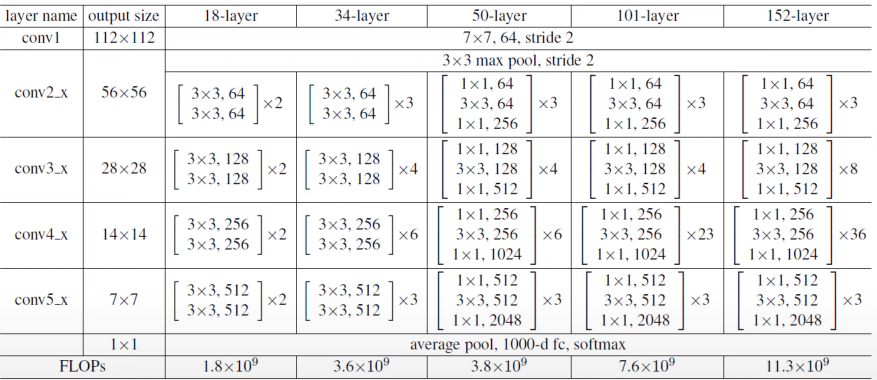

In [6]:
import torch
import torch.nn as nn

### About Identity downsample : 
#### The essential part here is to understand that the output from one block that needs to be added to the output of another block via a skip connection in the forward() of class block, The output of the previous block might have an incorrect dimensionality or number of channels and it needs to be downsampled before adding it and propogating the output forward. So the identity downsample takes care of that. Deetailed comments in the code

In [7]:
class block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4 #Final out_channels defined by this. in_channels*expansion.
        #Pay Attention to the Resnet 50 blocks for example. Each block performs 3 convolutional layers in total.
        #say look at the conv2_x row and 50-layer column. The first convolution is going to be with a filter of 1x1 and 64 channels ie intermediate channels.
        #Notice over here that the intermediate channel is the outchannel of the first convolution in the block but the last convolution in the block
        #produces an outchannel overall of self.expansion*intermediate channels for the block level. hence whatever the number of input channels
        #They get converted into intermediate channel and then another intermediate channel->intermediate channel conv and finally from intermediate channel to 
        #out_channel of 4*intermediate.
        self.conv1 = nn.Conv2d(in_channels,intermediate_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        #Stride is as defined in the paper for each sublayer of this block.
        self.conv2 = nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        #The padding is calculated as : (n+2p-f+1)/s = out so say for 64 intermediate : 64 + 2p -3 +1 = 64 p = 1. similarly for the output below.
        self.conv3 = nn.Conv2d(intermediate_channels,intermediate_channels * self.expansion,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)

        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

        self.stride = stride

    def forward(self, x):
        identity = x.clone()
        # Keep the initial input x and then also pass it through the convolutions as defined in the image from the paper above
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        # Now if there is downsampling or channel changes required in the x that you get perform those.
        # For clarity say that this is the second block of the first kind that is being run as in the image.
        # Then it is important to see that X is already going to be the required size as above. that is 
        # The first block of it's kind will reduce the 224 X 224 to 112 as stride is 1 and the channels of x
        # will become 256. then all subsequent blocks that are going to be run are going to have the channels as 256
        # Same as what we get when passing the 256 channel image into the block again, it will first become a 64 channel image
        # 2 times and then finally you will get back a 256 channel image because of the third convolution and so there is no need 
        # to downsample the skip connection X.
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity #skip connection
        x = self.relu(x)
        return x



In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [9]:

def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    BATCH_SIZE = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet101(img_channel=3, num_classes=1000).to(device)
    y = net(torch.randn(BATCH_SIZE, 3, 224, 224).to(device))
    assert y.size() == torch.Size([BATCH_SIZE, 1000])
    print(y.size())


if __name__ == "__main__":
    test()

torch.Size([4, 1000])
